# Simulate DNA segment with WLC

In [1]:
import random
import numpy as np
import torch

# Set a fixed seed value
seed = 98

# Python, NumPy, and PyTorch (CPU)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

rng = np.random.default_rng(seed)

# Only set CUDA seeds if a GPU is available
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Seeds set to {seed} (with CUDA: {torch.cuda.is_available()})")

Seeds set to 98 (with CUDA: False)


In [2]:
from __future__ import annotations
import math
from dataclasses import dataclass
from typing import List
import csv

@dataclass
class WLCParams:
    bp: int
    nm_per_bp: float
    lp_nm: float
    D_nm: float
    ds_nm: float
    n_chains: int
    seed: int

def rotate_tangent(t: np.ndarray, ds: float, lp: float, rng: np.random.Generator) -> np.ndarray:
    """
    Rotate unit tangent t by a small random angle on the unit sphere.
    For WLC in 3D: Var(theta) = 2 ds / lp.
    """
    # Build an orthonormal basis {e1, e2, t}
    a = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(a, t)) > 0.9:
        a = np.array([0.0, 1.0, 0.0])
    e1 = a - np.dot(a, t) * t
    e1 /= np.linalg.norm(e1)
    e2 = np.cross(t, e1)

    # Random 2D Gaussian in the perpendicular plane
    sigma = math.sqrt(2.0 * ds / lp)
    xi1, xi2 = rng.normal(size=2)
    dvec = sigma * (xi1 * e1 + xi2 * e2)
    dtheta = np.linalg.norm(dvec)
    if dtheta < 1e-12:
        return t.copy()
    k = dvec / dtheta

    # Rodrigues formula
    t_new = t * math.cos(dtheta) + np.cross(k, t) * math.sin(dtheta)
    return t_new / np.linalg.norm(t_new)


def reflect_at_plane(t: np.ndarray, normal: np.ndarray) -> np.ndarray:
    """Specular reflection of tangent across a plane with given unit normal."""
    return t - 2.0 * np.dot(t, normal) * normal


def propagate_step(r: np.ndarray, t: np.ndarray, ds: float, D: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Propagate by ds with reflections at channel walls.
    Channel axis: y (infinite).
    Confinement: 0 <= x <= D, 0 <= z <= D.
    """
    remaining = ds
    x, y, z = r
    tx, ty, tz = t

    while remaining > 0:
        hits = []
        # x walls
        if tx > 0: hits.append(((D - x) / tx, np.array([-1.0, 0.0, 0.0])))  # hit x=D
        if tx < 0: hits.append(((0.0 - x) / tx, np.array([ 1.0, 0.0, 0.0])))  # hit x=0
        # z walls
        if tz > 0: hits.append(((D - z) / tz, np.array([0.0, 0.0, -1.0])))   # hit z=D
        if tz < 0: hits.append(((0.0 - z) / tz, np.array([0.0, 0.0,  1.0]))) # hit z=0

        hits = [(d, n) for (d, n) in hits if d > 0]

        if not hits:
            # move full step
            x += remaining * tx; y += remaining * ty; z += remaining * tz
            remaining = 0.0
            break

        dmin, normal = min(hits, key=lambda p: p[0])

        if dmin >= remaining:
            x += remaining * tx; y += remaining * ty; z += remaining * tz
            remaining = 0.0
        else:
            # hit a wall
            x += dmin * tx; y += dmin * ty; z += dmin * tz
            remaining -= dmin
            # snap
            if normal[0] != 0:
                x = 0.0 if normal[0] > 0 else D
            if normal[2] != 0:
                z = 0.0 if normal[2] > 0 else D
            # reflect tangent
            t_vec = np.array([tx, ty, tz], dtype=float)
            t_vec = reflect_at_plane(t_vec, normal)
            t_vec /= np.linalg.norm(t_vec)
            tx, ty, tz = t_vec

    return np.array([x, y, z]), np.array([tx, ty, tz])


def simulate_chain(L_nm=306.0, ds_nm=0.2, lp_nm=50.0, D_nm=100.0, rng=None):
    """
    Simulate one WLC chain of contour length L_nm inside a square nanochannel
    of width D_nm along x,z. Axis is along y.
    """
    if rng is None:
        rng = np.random.default_rng(7)
    n_steps = int(round(L_nm / ds_nm))

    # start at y=0, random x,z inside channel; tangent along +y
    r = np.array([rng.uniform(0.0, D_nm), 0.0, rng.uniform(0.0, D_nm)], dtype=float)
    t = np.array([0.0, 1.0, 0.0], dtype=float)

    coords = np.empty((n_steps + 1, 3), dtype=float)
    coords[0] = r

    for i in range(n_steps):
        t = rotate_tangent(t, ds_nm, lp_nm, rng)
        r, t = propagate_step(r, t, ds_nm, D_nm)
        coords[i + 1] = r

    return coords



def end_to_end(coords: np.ndarray) -> float:
    return float(np.linalg.norm(coords[-1] - coords[0]))


def radius_of_gyration(coords: np.ndarray) -> float:
    cm = coords.mean(axis=0)
    return float(np.sqrt(((coords - cm) ** 2).sum(axis=1).mean()))


def simulate_many(params: WLCParams) -> List[np.ndarray]:
    """Run n_chains independent simulations."""
    rng = np.random.default_rng(params.seed)
    L_nm = params.bp * params.nm_per_bp
    chains: List[np.ndarray] = []
    for _ in range(params.n_chains):
        chains.append(simulate_chain(L_nm, params.ds_nm, params.lp_nm, params.D_nm, rng))
    return chains


def save_to_csv(chains: List[np.ndarray], ds_nm: float, out_path: str) -> None:
    """Save all coordinates to one CSV with columns: chain_id, s_nm, x_nm, y_nm, z_nm"""
    with open(out_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["chain_id", "s_nm", "x_nm", "y_nm", "z_nm"])
        for cid, coords in enumerate(chains):
            for i, (x, y, z) in enumerate(coords):
                writer.writerow([cid, i * ds_nm, x, y, z])


def main() -> None:
    params = WLCParams(
        bp=900,
        nm_per_bp=0.34,
        lp_nm=50.0,
        D_nm=20.0,     # <-- channel width (nm)
        ds_nm=1.0,
        n_chains=5,
        seed=seed,
    )

    # Simulate
    chains = simulate_many(params)

    # Quick summary
    e2e = [end_to_end(c) for c in chains]
    rg = [radius_of_gyration(c) for c in chains]
    print(f"Simulated {len(chains)} chains. ds = {params.ds_nm} nm, D = {params.D_nm} nm")
    print(f"End-to-end distance (nm): mean={np.mean(e2e):.2f}, std={np.std(e2e):.2f}")
    print(f"Radius of gyration (nm):  mean={np.mean(rg):.2f}, std={np.std(rg):.2f}")

    # Save coordinates
    out_csv = "dna_900bp_channel_WLC_D20.csv"
    save_to_csv(chains, params.ds_nm, out_csv)
    print(f"Saved coordinates to {out_csv}")


if __name__ == "__main__":
    main()


Simulated 5 chains. ds = 1.0 nm, D = 20.0 nm
End-to-end distance (nm): mean=66.43, std=28.64
Radius of gyration (nm):  mean=23.75, std=13.16
Saved coordinates to dna_900bp_channel_WLC_D20.csv


## display DNA

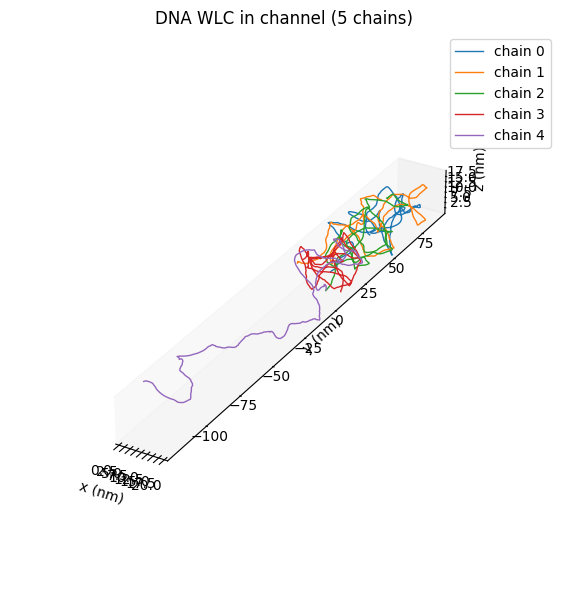

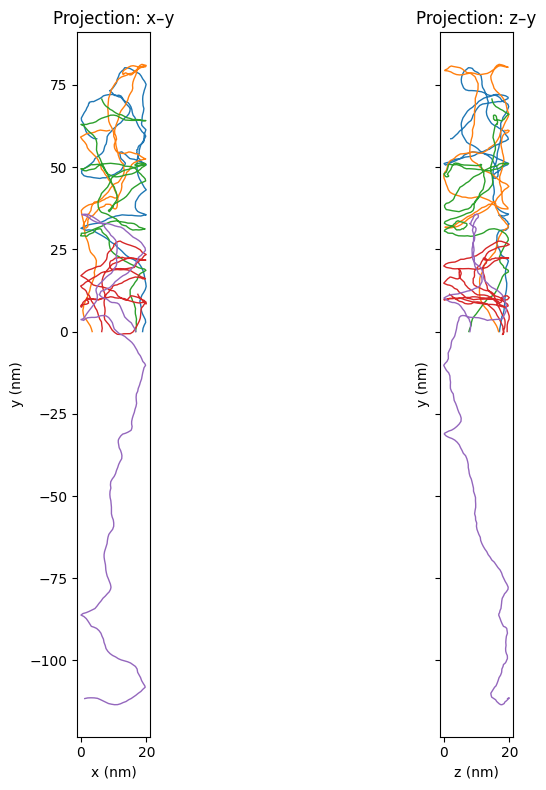

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV with DNA chains
df = pd.read_csv("dna_900bp_channel_WLC_D20.csv")

# Pick 5 random chain IDs (or just the first 5)
chain_ids = df["chain_id"].unique()[:5]

# 3D plot (for reference)
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
for cid in chain_ids:
    coords = df[df["chain_id"] == cid]
    ax.plot(coords["x_nm"], coords["y_nm"], coords["z_nm"], label=f"chain {cid}", linewidth=1.0)

ax.set_xlabel("x (nm)")
ax.set_ylabel("y (nm)")
ax.set_zlabel("z (nm)")
ax.set_title("DNA WLC in channel (5 chains)")
ax.set_aspect("equal", adjustable="box")
ax.grid(False)
ax.legend()
plt.tight_layout()
plt.show()

# 2D projections with y vertical
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

# x–y projection (y vertical)
for cid in chain_ids:
    coords = df[df["chain_id"] == cid]
    axes[0].plot(coords["x_nm"], coords["y_nm"], label=f"chain {cid}", linewidth=1.0)
axes[0].set_xlabel("x (nm)")
axes[0].set_ylabel("y (nm)")
axes[0].set_title("Projection: x–y")
axes[0].set_aspect("equal", adjustable="box")
# axes[0].legend()

# z–y projection (y vertical)
for cid in chain_ids:
    coords = df[df["chain_id"] == cid]
    axes[1].plot(coords["z_nm"], coords["y_nm"], label=f"chain {cid}", linewidth=1.0)
axes[1].set_xlabel("z (nm)")
axes[1].set_ylabel("y (nm)")
axes[1].set_title("Projection: z–y")
axes[1].set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


## sample random number of fluorofores along the segment

In [4]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Load DNA chain
df = pd.read_csv("dna_900bp_channel_WLC_D20.csv")

# Choose one chain (e.g., chain_id = 0)
chain_id = 0
coords = df[df["chain_id"] == chain_id][["x_nm", "y_nm", "z_nm"]].to_numpy()

# Compute arclength along contour
diffs = np.diff(coords, axis=0)
ds = np.linalg.norm(diffs, axis=1)
s = np.concatenate([[0.0], np.cumsum(ds)])  # cumulative arclength

# Interpolators for x, y, z vs contour length
fx = interp1d(s, coords[:, 0])
fy = interp1d(s, coords[:, 1])
fz = interp1d(s, coords[:, 2])

# Random number of samples between 10 and 100
rng = np.random.default_rng()
N = rng.integers(30, 200)
s_sample = np.sort(rng.uniform(0, s[-1], size=N))

# Interpolated positions
x_sample = fx(s_sample)
y_sample = fy(s_sample)
z_sample = fz(s_sample)

positions_nm = np.stack([x_sample, y_sample, z_sample], axis=1)  # shape (N, 3)
print(f"Sampled {N} points along DNA chain {chain_id}")
print(positions_nm[:5])  # first 5 for preview


Sampled 180 points along DNA chain 0
[[19.14876962  1.35628047 17.21482149]
 [19.38983074  1.97671541 17.33760116]
 [19.16531901  4.7498     17.84657897]
 [18.84804503  5.37386148 18.13663568]
 [18.41734328  7.36755339 18.47429736]]


# Deeptrack simulation

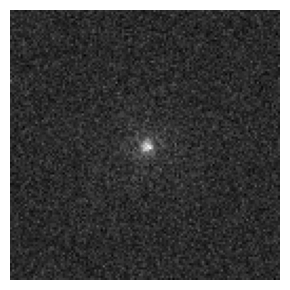

In [99]:
import deeptrack as dt

im_size = 128
center = im_size // 2
pixel_size = 86.0 # nm

particle = dt.PointParticle(
    all_coords=positions_nm/(pixel_size) + center,
    replicate_index=lambda _ID: _ID,
    coords=lambda replicate_index, all_coords:  all_coords[replicate_index],
    position=lambda coords: coords[:-1] * dt.units.pixel ,
    z=0,#lambda coords: coords[-1] * pixel_size * dt.units.nm,
    number_of_particles=positions_nm.shape[0],
    intensity=lambda number_of_particles: np.random.rand(number_of_particles),
)

# optics = dt.Fluorescence(
#     numerical_aperture=1.42,
#     wavelength=640*dt.units.nm,
#     medium_refractive_index=1.33,
#     resolution=pixel_size * dt.units.nm,
#     output_region=[0, 0, im_size, im_size],
#     magnification=1,
# )

spectrum = [480, 533, 640]

optics = [dt.Fluorescence(
    numerical_aperture=1.42,
    wavelength=wavelength*dt.units.nm,
    medium_refractive_index=1.33,
    resolution=pixel_size * dt.units.nm,
    output_region=[0, 0, im_size, im_size],
    magnification=1,
)
for wavelength in spectrum]


image = (sum([laser(particle^particle.number_of_particles)
    for laser in optics])
    >> dt.Add(3)
    >> dt.Poisson(snr=3E1)
)


# image = (
#     optics(particle^particle.number_of_particles)
#     >> dt.Add(0.3)
#     >> dt.Poisson(snr=.8E1)
# )

# Convert crop into NumPy array.
sim = np.squeeze(image())

# Plot the simulated and experimental crops.
fig = plt.figure(figsize=(3, 3))

# Simulated crop.
plt.imshow(sim, cmap="gray")
plt.axis("off")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()


## check histogram

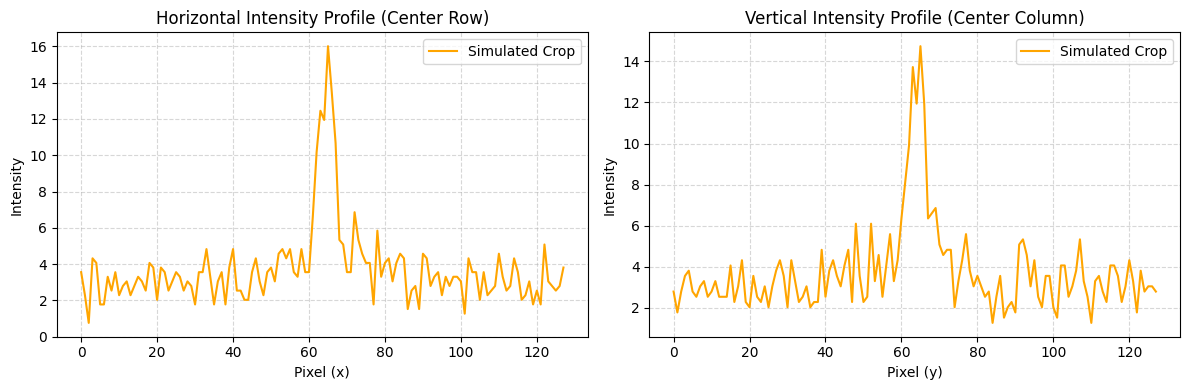

In [100]:
# Extract horizontal (row) profiles.
sim_horiz = sim[center, :]

# Extract vertical (column) profiles.
sim_vert = sim[:, center]

# Create a 1×2 subplot.
fig, axes = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

# --- Horizontal profile ---
axes[0].plot(sim_horiz, label="Simulated Crop", color="orange")
axes[0].set_xlabel("Pixel (x)")
axes[0].set_ylabel("Intensity")
axes[0].set_title("Horizontal Intensity Profile (Center Row)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Vertical profile ---
axes[1].plot(sim_vert, label="Simulated Crop", color="orange")
axes[1].set_xlabel("Pixel (y)")
axes[1].set_ylabel("Intensity")
axes[1].set_title("Vertical Intensity Profile (Center Column)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# Prism (chromatic dispersion)

In [101]:
import numpy as np
import deeptrack as dt

def n_bk7_sellmeier(lam_nm: float) -> float:
    """BK7 refractive index at wavelength λ in nm (Sellmeier)."""
    lam_um = lam_nm / 1000.0
    B1, B2, B3 = 1.03961212, 0.231792344, 1.01046945
    C1, C2, C3 = 6.00069867e-3, 2.00179144e-2, 1.03560653e2
    lam2 = lam_um**2
    return np.sqrt(1 + (B1*lam2)/(lam2-C1) + (B2*lam2)/(lam2-C2) + (B3*lam2)/(lam2-C3))

class PrismPupilPhase(dt.Feature):
    def __init__(self, apex_angle_deg=10, direction="x", pixels_per_rad=1e4,
                 wavelength_nm=550, **kwargs):
        super().__init__(**kwargs)
        self.apex_angle = np.deg2rad(apex_angle_deg)
        self.direction = direction
        self.pixels_per_rad = pixels_per_rad
        self.wavelength_nm = wavelength_nm   # float or callable

    def _to_nm(self, wl) -> float:
        """Convert DeepTrack unit or lambda -> nm float."""
        if wl is None:
            wl = self.wavelength_nm() if callable(self.wavelength_nm) else self.wavelength_nm
        try:
            return float(wl / dt.units.nm)
        except Exception:
            return float(wl)

    def _theta(self, lam_nm: float) -> float:
        """Deviation angle (radians) for wavelength lam_nm (nm)."""
        n = n_bk7_sellmeier(lam_nm)
        return (n - 1) * self.apex_angle

    def get(self, pupil_function, **kwargs):
        lam_nm = self._to_nm(kwargs.get("wavelength", None))
        theta = self._theta(lam_nm)
        shift_px = self.pixels_per_rad * theta

        H, W = pupil_function.shape
        u = (np.arange(W) - W/2) / W
        v = (np.arange(H) - H/2) / H
        U, V = np.meshgrid(u, v)
        axis = U if self.direction == "x" else V

        phase = 2*np.pi * shift_px * axis
        return pupil_function * np.exp(1j * phase)


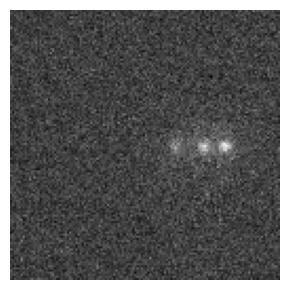

In [104]:
spectrum = [480, 533, 640]

particle = dt.PointParticle(
    all_coords=positions_nm/(pixel_size) + center,
    replicate_index=lambda _ID: _ID,
    coords=lambda replicate_index, all_coords:  all_coords[replicate_index],
    position=lambda coords: coords[:-1] * dt.units.pixel ,
    z=lambda coords: coords[-1] * pixel_size * dt.units.nm,
    number_of_particles=positions_nm.shape[0],
    intensity=lambda number_of_particles: np.random.rand(number_of_particles),
)

optics = [dt.Fluorescence(
    numerical_aperture=1.42,
    wavelength=wl*dt.units.nm,
    medium_refractive_index=1.33,
    resolution=pixel_size * dt.units.nm,
    output_region=[0, 0, im_size, im_size],
    magnification=1,
    pupil=PrismPupilPhase(
            apex_angle_deg=20,
            direction="x",
            pixels_per_rad=-8190.0,
            wavelength_nm=lambda wl=wl: wl   # << lambda captures wl from the loop
        ),
)
for wl in spectrum]


image = (sum([laser(particle^particle.number_of_particles)
    for laser in optics])
    >> dt.Add(3)
    >> dt.Poisson(snr=3E1)
)

# Convert crop into NumPy array.
sim = image()

# Plot the simulated and experimental crops.
fig = plt.figure(figsize=(3, 3))

# Simulated crop.
plt.imshow(sim, cmap="gray")
plt.axis("off")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()


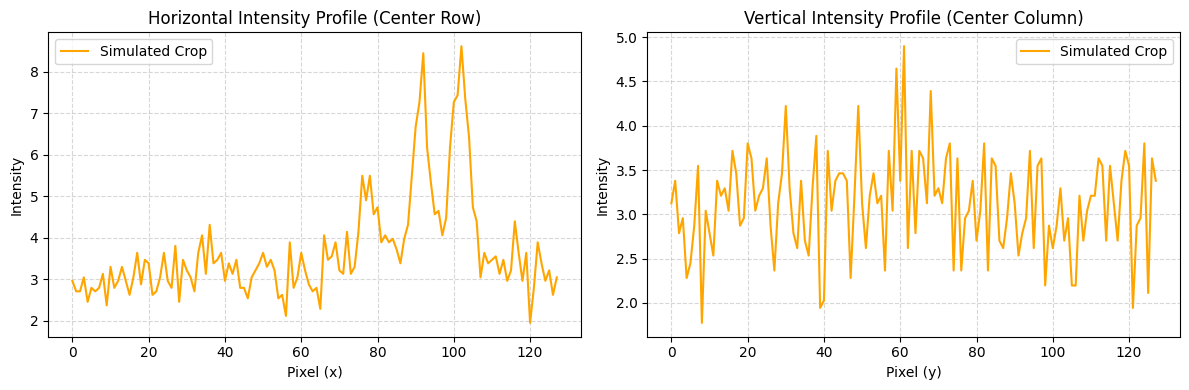

In [105]:
# Extract horizontal (row) profiles.
sim_horiz = sim[center, :]

# Extract vertical (column) profiles.
sim_vert = sim[:, center]

# Create a 1×2 subplot.
fig, axes = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

# --- Horizontal profile ---
axes[0].plot(sim_horiz, label="Simulated Crop", color="orange")
axes[0].set_xlabel("Pixel (x)")
axes[0].set_ylabel("Intensity")
axes[0].set_title("Horizontal Intensity Profile (Center Row)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Vertical profile ---
axes[1].plot(sim_vert, label="Simulated Crop", color="orange")
axes[1].set_xlabel("Pixel (y)")
axes[1].set_ylabel("Intensity")
axes[1].set_title("Vertical Intensity Profile (Center Column)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)